# Nightly Price Prediction (MXN) with XGBoost

**Project:** Non-linear regression model to improve price prediction accuracy.

**Dataset:** `database.csv`

**Goals:**
- Prepare data with categorical and numeric variables.
- Train an `XGBRegressor` model.
- Evaluate with regression metrics and compare actual vs prediction.


In [1]:
# Dependencias
# If you do not have xgboost installed, run:
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from xgboost import XGBRegressor

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load data
file_path = "../database.csv"
df = pd.read_csv(file_path)

df.head()

,Estado,Ciudad,Colonia/Municipio,Tipo de alojamiento,Numero de cuartos,Numero de baños,Numero de huéspedes,Precio por noche estimado (MXN),Ocupación promedio (%)
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Cleaning and column normalization


In [3]:
rename_map = {
    "Numero de cuartos": "num_cuartos",
    "Numero de baños": "num_banos",
    "Numero de huéspedes": "num_huespedes",
    "Precio por noche estimado (MXN)": "precio_noche_mxn",
    "Ocupación promedio (%)": "ocupacion_promedio",
    "Tipo de alojamiento": "tipo_alojamiento",
    "Colonia/Municipio": "colonia_municipio",
}

df = df.rename(columns=rename_map)

df.head()

,Estado,Ciudad,colonia_municipio,tipo_alojamiento,num_cuartos,num_banos,num_huespedes,precio_noche_mxn,ocupacion_promedio
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Feature and target preparation


In [4]:
features = [
    "Estado",
    "Ciudad",
    "colonia_municipio",
    "tipo_alojamiento",
    "num_cuartos",
    "num_banos",
    "num_huespedes",
    "ocupacion_promedio",
]

target = "precio_noche_mxn"

X = df[features]
y = df[target]

In [5]:
categorical_features = ["Estado", "Ciudad", "colonia_municipio", "tipo_alojamiento"]
numeric_features = ["num_cuartos", "num_banos", "num_huespedes", "ocupacion_promedio"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

## XGBoost model
We start with reasonable hyperparameters; with more data you can tune further.


In [6]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model),
    ]
)

In [7]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Estado', 'Ciudad',
                                                   'colonia_municipio',
                                                   'tipo_alojamiento']),
                                                 ('num', 'passthrough',
                                                  ['num_cuartos', 'num_banos',
                                                   'num_huespedes',
                                                   'ocupacion_promedio'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, c...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [8]:
# Evaluación
preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 100.42
RMSE: 168.59
R2: 0.99


## Actual vs prediction comparison


In [9]:
comparison = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": preds
})

comparison.head()

,Real,Predicción
0,1250,1260.649048
1,1500,1558.569824
2,750,773.570007
3,1350,1387.165039
4,2500,2638.048340


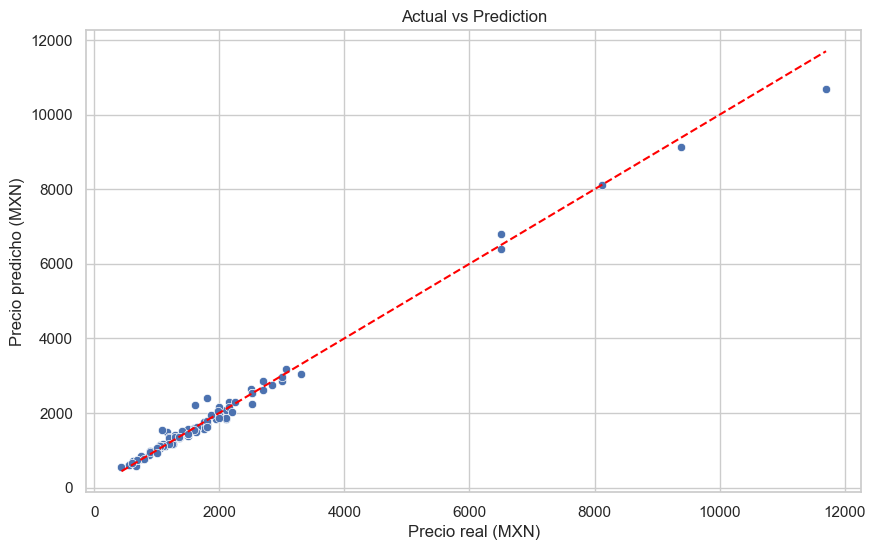

In [10]:
sns.scatterplot(data=comparison, x="Real", y="Predicción")
plt.plot([comparison["Real"].min(), comparison["Real"].max()],
         [comparison["Real"].min(), comparison["Real"].max()],
         color="red", linestyle="--")
plt.title("Actual vs Prediction")
plt.xlabel("Precio real (MXN)")
plt.ylabel("Precio predicho (MXN)")
plt.show()

## Feature importance (approximate)
XGBoost provides importance for encoded categorical and numeric features.


In [11]:
# Extraer nombres de columnas después de OneHotEncoding
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = pipeline.named_steps["model"].feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi.head(15)

,feature,importance
2,cat__Estado_Baja California Sur,0.302436
34,cat__Ciudad_Cabo San Lucas,0.266990
48,cat__Ciudad_La Paz,0.135595
70,cat__Ciudad_San José del Cabo,0.087852
17,cat__Estado_Nayarit,0.027636
22,cat__Estado_Quintana Roo,0.013113
6,cat__Estado_Ciudad de México,0.012695
66,cat__Ciudad_Puerto Vallarta,0.011491
80,cat__Ciudad_Valle de Bravo,0.007660
11,cat__Estado_Guerrero,0.007388


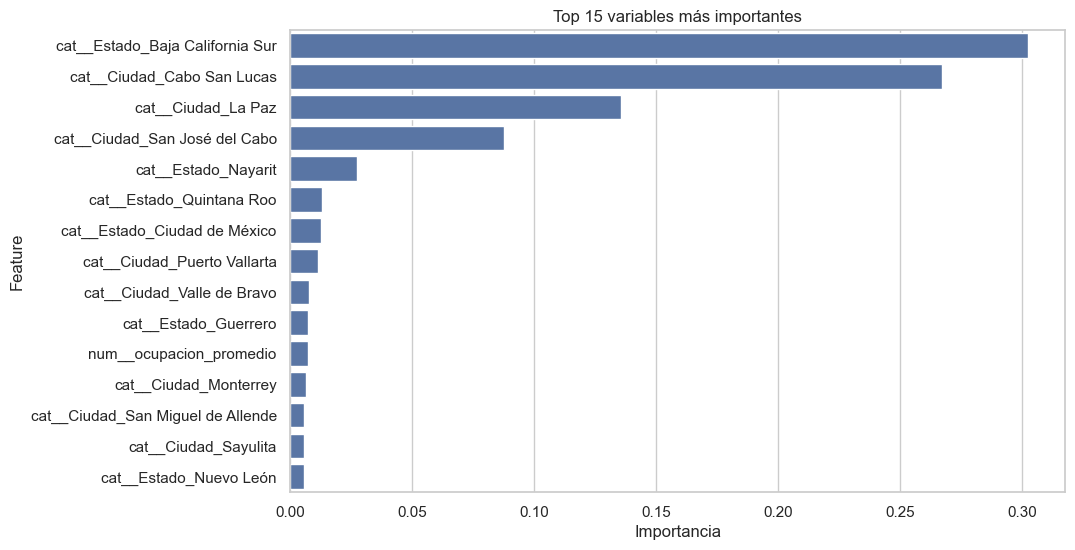

In [12]:
# Visualizar top 15
sns.barplot(data=fi.head(15), y="feature", x="importance")
plt.title("Top 15 variables más importantes")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()

## Conclusions
- XGBoost can capture non-linear relationships better than linear models.
- Tune hyperparameters and add more data for better accuracy.
